In [1]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

    1> /scratch/p66/dhb599/archive/cq880C/history/ocn/ocean-scalar-1-daily-ym_0411_07.nc
    2> /scratch/p66/dhb599/archive/cq880C/history/ocn/ocean-scalar-1-daily-ym_0311_07.nc
    3> /g/data/p66/mrd599/cq880/history/ocn/ocean-scalar-1-daily-ym_0301_07.nc
    4> /g/data/p73/archive/non-CMIP/ACCESS-CM2/cj877/history/ocn/ocean-scalar-1-daily-ym_0301_07.nc
    5> /g/data/p73/archive/non-CMIP/ACCESS-CM2/cj877/history/ocn/ocean-scalar-1-daily-ym_0101_07.nc
    6> /g/data/p73/archive/non-CMIP/ACCESS-CM2/cj877/history/ocn/ocean-scalar-1-daily-ym_0001_07.nc
    16> /g/data/p73/archive/non-CMIP/ACCESS-CM2/cj877/history/ocn/ocean-3d-pot_temp-1-monthly-mean-ym_0001_01.nc  (default)


In [2]:
# --- read data ---
idir = '/g/data/p73/archive/non-CMIP/ACCESS-CM2/cj877/history/ocn/'
v1Name = 'ocean-scalar-1-daily-ym_*'

# Open a netCDF data file using xarray default engine and load the data into xarrays
fname = idir+v1Name
ds = xr.open_mfdataset(fname, combine='by_coords')

# Use date as the dimension rather than time
year_start = 550
year_end = 599
#df = ds.sel(time=(ds['time.year'] >= year_start) & (ds['time.year'] <= year_end)) # 192 x 144


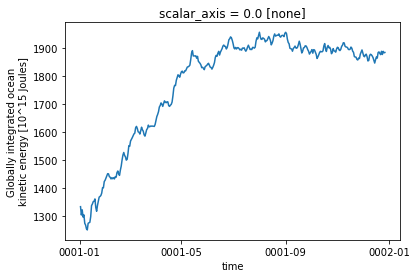

In [3]:
ds.ke_tot[0:360].plot()

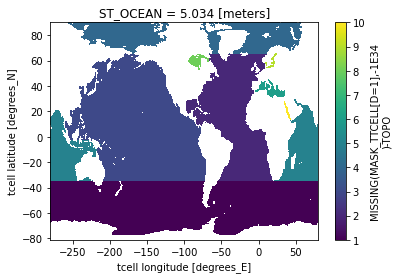

In [2]:
mskName = "/g/data/p66/ars599/plot_paper_data/lsmask_surface_ceil_hires_07052015.nc"
idir = "/scratch/p66/dhb599/archive/cq880C/history/ocn/"
tyName = "ocean-3d-ty_trans-1-monthly-mean-ym_0417_01.nc"
tygmName = "ocean-3d-ty_trans_gm-1-monthly-mean-ym_0417_01.nc"
tymesoName = "ocean-3d-ty_trans_submeso-1-monthly-mean-ym_0417_01.nc"

mskds = xr.open_dataset(mskName)
trds = xr.open_dataset(idir+tyName)
trgmds = xr.open_dataset(idir+tygmName)
trmesods = xr.open_dataset(idir+tymesoName)

msk = mskds.MASK_TTCELL_3D
ty_trans = trds.ty_trans
ty_trans_gm = trgmds.ty_trans_gm
ty_trans_submeso = trmesods.ty_trans_submeso

msk[0].plot()

In [5]:
ty_trans

<xarray.DataArray 'ty_trans' (time: 6, st_ocean: 50, yu_ocean: 1080,
                              xt_ocean: 1440)>
[466560000 values with dtype=float32]
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yu_ocean  (yu_ocean) float64 -81.02 -80.92 -80.81 ... 89.79 89.89 90.0
  * st_ocean  (st_ocean) float64 1.152 3.649 6.565 ... 5.034e+03 5.254e+03
  * time      (time) object 0417-01-16 12:00:00 ... 0417-06-16 00:00:00
Attributes:
    long_name:      T-cell j-mass transport
    units:          kg/s
    valid_range:    [-1.e+20  1.e+20]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_c
    standard_name:  ocean_mass_y_transport

In [3]:
#Calculate the y_overturning mass streamfunction
#For three basins:
#0 Atlantic-Arctic
#1 Indian-Pacific basin
#2 Global Basin
def meridionalOverturning(transList,typ,om2=1):
#TODO remove masks once satified with these calculations
    ty_trans=transList[0]
    #print type(ty_trans), np.shape(ty_trans) ,np.shape(ty_trans.mask)
    #initialise array
    dims=list(np.shape(ty_trans[:,:,:,0])) +[3] #remove x, add dim for 3 basins
    transports= np.ma.zeros(dims,dtype=np.float32)
    #first calculate for global basin
    #2: global basin
    print('working on global basin')
    transports[:,:,:,2]=calcOverturning(transList,typ)
    try:
        if ty_trans.mask==False:
        #if there is no mask: set masks to arrays of zeros
            for trans in transList:
                trans.mask=np.zeros(np.shape(trans),dtype=bool)
    except: pass
    #grab land mask out of ty_trans file (assuming the only masked values are land)
    landMask=np.array(ty_trans.mask[0,:,:,:],dtype=bool)
    #Get basin masks
    if om2 == 0o25:
        mask=getBasinMask_025()
    else:
        mask=getBasinMask()
    #0: atlantic arctic basin
    #set masks
    #atlantic and arctic basin are given by mask values 2 and 4 #TODO double check this
    atlantic_arctic_mask=np.ma.make_mask(np.logical_and(mask!=2.0,mask!=4.0))
    for t in range(np.shape(ty_trans)[0]):
        for z in range(np.shape(ty_trans)[1]):
            for trans in transList:
                trans.mask[t,z,:,:]=np.ma.mask_or(atlantic_arctic_mask,landMask[z,:,:])
    #calculate MOC with atlantic basin mask
    print('working on atl basin')
    transports[:,:,:,0]=calcOverturning(transList,typ)
    #1: indoPacific basin:
    #set masks
    #Indian and Pacific basin are given by mask values 3 and 5 #TODO double check this
    indoPac_mask=np.ma.make_mask(np.logical_and(mask!=3.0,mask!=5.0))
    for t in range(np.shape(ty_trans)[0]):
        for z in range(np.shape(ty_trans)[1]):
            for trans in transList:
                trans.mask[t,z,:,:]=np.ma.mask_or(indoPac_mask,landMask[z,:,:])
    print('working on indoPac basin')
    transports[:,:,:,1]=calcOverturning(transList,typ)
    return transports



#calculate overturning circulation depending on what inputs are given
def calcOverturning(transList,typ):
    #assumes transList is a list of variables:
    #ty_trans, ty_trans_gm, ty_trans_submeso
    #where the gm and submeso quantities may or may not exist
    #gm = bolus
    #
    #Calculation is:
    #sum over the longditudes and
    #for ty_trans run a cumalative sum over depths (not for gm or submeso)
    #The result for each variable in transList are added together
    typ=typ.split('_')
    n=len(transList)
    print('type = ',typ)
    print('n = ',n)
    if len(typ)==1:
        #normal case for cmip5, need to convert units
        # gm and submeso quantities are output in Sv so need to be multiplied by 10**9
        typ=typ[0]
        if n==1:
            if typ=='bolus':
                #should be bolus transport for rho levels
                return transList[0].sum(3) #*10**9
        elif n==2:
            if typ=='bolus':
                #bolus advection is sum of gm and submeso
                return ( transList[0].sum(3)+transList[1].sum(3) ) #*10**9
            elif typ=='full':
                #full y overturning on rho levels, where trans and trans_gm are present (no submeso)
                tmp= transList[0].sum(3).cumsum(1)+transList[1].sum(3) #*10**9
                s=transList[0].sum(3).sum(1)
                for i in range(tmp.shape[1]):
                    tmp[:,i,:]=tmp[:,i,:]-s
                return tmp
        elif n==3:
            #assume full y overturning:
            #trans + trans_gm +trans_submeso
            if typ=='full':
                tmp=transList[0].sum(3).cumsum(1)+transList[1].sum(3)+transList[2].sum(3)
                s=transList[0].sum(3).sum(1)
                for i in range(tmp.shape[1]):
                    tmp[:,i,:]=tmp[:,i,:]-s
                return tmp
    elif typ[1]=='Sv':
        #case from old diagnostics, units all in sieverts
        typ=typ[0]
        if n==1:
            if typ=='bolus':
                #should be bolus transport for rho levels
                return transList[0].sum(3)
        elif n==2:
            if typ=='bolus':
                #bolus advection is sum of gm and submeso
                return transList[0].sum(3)+transList[1].sum(3)
            elif typ=='full':
                #full y overturning on rho levels, where trans and trans_gm are present (no submeso)
                tmp= transList[0].sum(3).cumsum(1)+transList[1].sum(3)
                s=transList[0].sum(3).sum(1)
                for i in range(tmp.shape[1]):
                    tmp[:,i,:]=tmp[:,i,:]-s
                return tmp
        elif n==3:
            #assume full y overturning:
            #trans + trans_gm +trans_submeso
            if typ=='full':
                tmp=transList[0].sum(3).cumsum(1)+transList[1].sum(3)+transList[2].sum(3)
                s=transList[0].sum(3).sum(1)
                for i in range(tmp.shape[1]):
                    tmp[:,i,:]=tmp[:,i,:]-s
                return tmp


* app/coupled/rose-app.conf:# Need an O025 version
* app/coupled/rose-app.conf:source=/g/data/ik11/inputs/access-om2/input_20201102/mom_025deg/chl.nc
* app/coupled/rose-app.conf:# source=~access/access-cm2/input_O025/mom5_1440x1080/chl.nc
* app/coupled/rose-app.conf:source=~access/access-cm2/input_O025/mom4/data_table
* app/coupled/rose-app.conf:source=/scratch/p66/mrd599/access-cm2-025/ocean/diag_table
* app/coupled/rose-app.conf:source=~access/access-cm2/input_O025/mom5_1440x1080/field_table_OM2
* app/coupled/rose-app.conf:source=/g/data/ik11/inputs/access-om2/input_20201102/mom_025deg/grid_spec.nc
* app/coupled/rose-app.conf:source=/g/data/ik11/inputs/access-om2/input_20201102/mom_025deg/ocean_mosaic.nc
* app/coupled/rose-app.conf:source=/g/data/ik11/inputs/access-om2/input_20201102/mom_025deg/ocean_mask.nc
* app/coupled/rose-app.conf:source=/g/data/ik11/inputs/access-om2/input_20201102/mom_025deg/ocean_hgrid.nc
* app/coupled/rose-app.conf:source=/g/data/ik11/inputs/access-om2/input_20201102/mom_025deg/ocean_vgrid.nc
* app/coupled/rose-app.conf:source=/g/data/ik11/inputs/access-om2/input_20201102/mom_025deg/roughness_amp.nc
* app/coupled/rose-app.conf:source=/g/data/ik11/inputs/access-om2/input_20201102/mom_025deg/roughness_cdbot.nc
* app/coupled/rose-app.conf:source=/g/data/ik11/inputs/access-om2/input_20201102/mom_025deg/tideamp.nc
* app/coupled/rose-app.conf:source=/g/data/ik11/inputs/access-om2/input_20211125_025deg_topog/mom_025deg/topog.nc
* app/coupled/rose-app.conf:source=/scratch/p66/mrd599/access-cm2-025/ocean/mask_table.150.32x24
* app/fcm_make_drivers/rose-app.conf:config_base=https://trac.nci.org.au/svn/access_tools/access-cm2-drivers/branches/dev/mrd599/O025
* app/install_cold/rose-app.conf:source=~access/access-cm2/input_O025/cpl_n96/a2i_OM2.nc
* app/install_cold/rose-app.conf:source=~access/access-cm2/input_O025/cpl_1440x1080/i2a_OM2.nc
* app/install_cold/rose-app.conf:source=~access/access-cm2/input_O025/cpl_1440x1080/o2i_OM2.nc
* app/install_cold/rose-app.conf:source=/g/data/ik11/inputs/access-om2/input_20201102/cice_025deg/monthly_sstsss.nc
* app/install_cold/rose-app.conf:source=/g/data/ik11/inputs/access-om2/input_20201102/mom_025deg/ocean_temp_salt.res.nc


* d /g/data/p66/ars599/access_cm_025-picontrol/month/
* total 792
* drwxr-x--- 2 ars599 p66   4096 Oct 27  2015 ./
* drwxr-x--- 4 ars599 p66   4096 Oct 26  2015 ../
* -rw------- 1 ars599 p66  46984 Oct 26  2015 access_cm_025-picontrol.ocean_tg_month.cdf
* -rw------- 1 ars599 p66 372988 Oct 26  2015 access_cm_025-picontrol.ocean_tz_month.cdf
* -rw------- 1 ars599 p66 372988 Oct 27  2015 access_cm_025-picontrol.ocean_tz_month.nc


* 1 & 3 are the same !!!
*    1> /g/data/access/projects/access/access-cm2/input_O025/cpl_n96/a2i_26fields_8.5.nc
*    2> /g/data/access/projects/access/access-cm2/input_O025/cpl_n96/a2i_OM2.nc
*    3> /g/data/access/projects/access/access-cm2/input_O025/cpl_n96/a2i_28fields_GA7.nc  (default)


In [19]:
'''
test on one degree mom outputs
'''
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from dask.diagnostics import ProgressBar
import matplotlib.ticker as mticker
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

mskName = "/g/data/p66/ars599/plot_paper_data/lsmask_surface_ceil.nc"
idir = "/scratch/p66/ars599/archive/cw787/history/ocn/"
vName = "ocean_month.nc-19590630"

mskds = xr.open_dataset(mskName)
ds = xr.open_dataset(idir+vName)


In [12]:

msk = mskds.mask_ttcell
ty_trans = ds.ty_trans
ty_trans_gm = ds.ty_trans_gm
ty_trans_submeso = ds.ty_trans_submeso

transList = [ty_trans,ty_trans_gm,ty_trans_submeso]
transList[0]

<xarray.DataArray 'ty_trans' (time: 6, st_ocean: 50, yu_ocean: 300,
                              xt_ocean: 360)>
array([[[[nan, ..., nan],
         ...,
         [nan, ..., nan]],

        ...,

        [[nan, ..., nan],
         ...,
         [nan, ..., nan]]],


       ...,


       [[[nan, ..., nan],
         ...,
         [nan, ..., nan]],

        ...,

        [[nan, ..., nan],
         ...,
         [nan, ..., nan]]]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * time      (time) datetime64[ns] 1959-01-16T12:00:00 ... 1959-06-16
  * yu_ocean  (yu_ocean) float64 -77.75 -77.51 -77.26 -77.01 ... 89.1 89.55 90.0
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
Attributes:
    long_name:      T-cell j-mass transport
    units:          kg/s
    valid_range:    [-1.e+20  1.e+20]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  ocean_y_mass_transport

In [14]:
transList[0].sum('xt_ocean').cumsum('st_ocean')

<xarray.DataArray 'ty_trans' (time: 6, st_ocean: 50, yu_ocean: 300)>
array([[[ 0.0000000e+00, -1.6214893e+08, -2.5848259e+08, ...,
         -9.6871872e+07, -4.8217184e+07,  2.0000000e+00],
        [ 0.0000000e+00, -3.2064064e+08, -4.8294787e+08, ...,
         -1.6110461e+08, -8.2142048e+07,  1.0000000e+01],
        [ 0.0000000e+00, -4.6669277e+08, -6.8862611e+08, ...,
         -1.9752277e+08, -9.0549920e+07,  1.0000000e+01],
        ...,
        [ 0.0000000e+00, -3.5114940e+06, -4.1108490e+06, ...,
         -9.9719120e+06, -8.4796820e+06,  1.5000000e+00],
        [ 0.0000000e+00, -3.5114940e+06, -4.1108490e+06, ...,
         -9.9719120e+06, -8.4796820e+06,  1.5000000e+00],
        [ 0.0000000e+00, -3.5114940e+06, -4.1108490e+06, ...,
         -9.9719120e+06, -8.4796820e+06,  1.5000000e+00]],

       [[ 0.0000000e+00, -9.3620640e+07, -1.7864488e+08, ...,
          9.6961920e+06,  1.7878912e+07,  0.0000000e+00],
        [ 0.0000000e+00, -2.6136251e+08, -4.5391552e+08, ...,
          2.9150724e+07,  2.8204556e+07, -8.0000000e+00],
        [ 0.0000000e+00, -4.2602829e+08, -7.0651597e+08, ...,
          5.7329000e+07,  4.5542008e+07, -8.0000000e+00],
...
        [ 0.0000000e+00, -2.2936304e+07, -3.3768972e+07, ...,
          2.2503110e+07,  1.2969186e+07,  5.0500000e+01],
        [ 0.0000000e+00, -2.2936304e+07, -3.3768972e+07, ...,
          2.2503110e+07,  1.2969186e+07,  5.0500000e+01],
        [ 0.0000000e+00, -2.2936304e+07, -3.3768972e+07, ...,
          2.2503110e+07,  1.2969186e+07,  5.0500000e+01]],

       [[ 0.0000000e+00, -1.1371055e+08, -6.7694552e+07, ...,
         -3.1511776e+07, -2.0460416e+07,  6.4000000e+01],
        [ 0.0000000e+00, -2.7223795e+08, -2.1338819e+08, ...,
         -3.9049472e+07, -1.9700976e+07,  3.2000000e+01],
        [ 0.0000000e+00, -4.3994880e+08, -3.8419418e+08, ...,
         -1.5091000e+07, -8.4599200e+05,  4.0000000e+01],
        ...,
        [ 0.0000000e+00, -1.8173898e+07, -2.7968612e+07, ...,
         -1.3787070e+06, -9.0685400e+06,  7.9000000e+01],
        [ 0.0000000e+00, -1.8173898e+07, -2.7968612e+07, ...,
         -1.3787070e+06, -9.0685400e+06,  7.9000000e+01],
        [ 0.0000000e+00, -1.8173898e+07, -2.7968612e+07, ...,
         -1.3787070e+06, -9.0685400e+06,  7.9000000e+01]]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 1959-01-16T12:00:00 ... 1959-06-16
  * yu_ocean  (yu_ocean) float64 -77.75 -77.51 -77.26 -77.01 ... 89.1 89.55 90.0
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03

In [23]:
tmp=transList[0].sum('xt_ocean').cumsum('st_ocean')+transList[1].sum('xt_ocean')+transList[2].sum('xt_ocean')
s=transList[0].sum('xt_ocean').sum('st_ocean')
for i in range(tmp.shape[1]):
    tmp[:,i,:]=tmp[:,i,:]-s
tmp = tmp * 1e-9
tmp

<xarray.DataArray (time: 6, st_ocean: 50, yu_ocean: 300)>
array([[[ 0.0000000e+00, -1.4738475e-01, -2.5347939e-01, ...,
         -1.3502291e-01, -6.1133958e-02,  8.1601283e-03],
        [ 0.0000000e+00, -2.9366308e-01, -4.7597650e-01, ...,
         -1.8985605e-01, -8.1620261e-02,  2.6975311e-02],
        [ 0.0000000e+00, -4.2959109e-01, -6.8321776e-01, ...,
         -1.9598332e-01, -6.8815783e-02,  3.5422552e-02],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[ 0.0000000e+00, -5.4571893e-02, -1.5331522e-01, ...,
          1.7471358e-02,  1.7083786e-02, -6.4566120e-04],
        [ 0.0000000e+00, -1.8030186e-01, -4.0443027e-01, ...,
          3.8753439e-02,  1.5133157e-02,  5.8297049e-03],
        [ 0.0000000e+00, -3.1432912e-01, -6.4226824e-01, ...,
          8.3505854e-02,  3.5479840e-02,  9.5449127e-03],
...
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],

       [[ 0.0000000e+00, -4.5401719e-01, -3.5583714e-01, ...,
         -8.0521151e-02, -4.1079920e-02, -3.2566534e-03],
        [ 0.0000000e+00, -1.0852398e+00, -9.6052676e-01, ...,
         -1.0278362e-01, -4.8405755e-02, -4.9576811e-03],
        [ 0.0000000e+00, -1.6918451e+00, -1.5163848e+00, ...,
         -7.3756643e-02, -2.5311364e-02, -3.3052079e-03],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00]]], dtype=float32)
Coordinates:
  * time      (time) datetime64[ns] 1959-01-16T12:00:00 ... 1959-06-16
  * yu_ocean  (yu_ocean) float64 -77.75 -77.51 -77.26 -77.01 ... 89.1 89.55 90.0
  * st_ocean  (st_ocean) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03

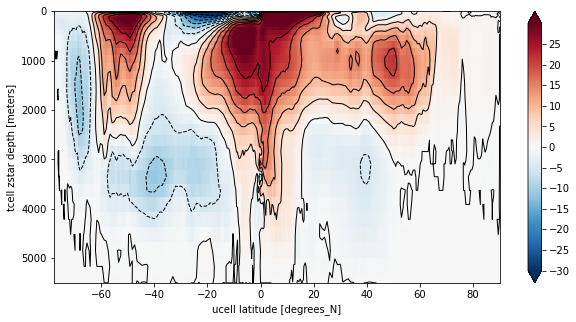

In [22]:
with ProgressBar():
    gmoc_mean = tmp.mean('time').load()

fig, ax = plt.subplots(figsize=(10,5))
gmoc_mean.plot(ax=ax, yincrease=False,vmin=-30,vmax=30,cmap='RdBu_r',cbar_kwargs={'ticks': np.arange(-30,30,5)})
gmoc_mean.plot.contour(ax=ax, yincrease=False, levels=np.concatenate([np.arange(-30,0,5),np.arange(0,30,5)]),
                      colors='k', linewidths=1)
ax.set_facecolor('grey')
ax.set_ylim([5500,0])
#plt.savefig('/g/data/p66/ars599/work_moc/gmoc_cj877', dpi=120)
plt.show()